<a href="https://colab.research.google.com/github/79AceVo/Text-analytics/blob/main/Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Text Classification Full Example

---



In [50]:
import pandas as pd
import numpy as np
import zipfile
from pathlib import Path
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from gensim.models.doc2vec import TaggedDocument
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [2]:
# download the BBC news blob (zip files)
#the files contain 5 folders, each folder is a news category. Each news are in a text format

!gdown 1eT3uD2ihxDEt2r2GJE6HeB_uhkgzh75V

#if gdown doesn't work, go to Brightspace and upload bbc.zip

Downloading...
From: https://drive.google.com/uc?id=1eT3uD2ihxDEt2r2GJE6HeB_uhkgzh75V
To: /content/bbc.zip
100% 2.90M/2.90M [00:00<00:00, 14.7MB/s]


In [6]:
#unzip file and put in a df with three columns: topic, heading, body
with zipfile.ZipFile('/content/bbc.zip', 'r') as zip_ref:
    topic = []
    heading = []
    body =[]
    for filename in zip_ref.namelist():
        if filename.endswith('.txt'):
            with zip_ref.open(filename) as f:
                text = f.read()
                text = text.decode("latin1").split("\n")
                indiv_heading = text[0]
                heading.append(indiv_heading)
                indiv_body = ' '.join([l.strip() for l in text[1:]]).strip()
                body.append(indiv_body)
                topic.append(Path(filename).parent.name)

news_df = pd.DataFrame({'topic': topic,'heading':heading,'body':body})
news_df.head()

,topic,heading,body
0,business,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarner...
1,business,Dollar gains on Greenspan speech,The dollar has hit its highest level against t...
2,business,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuko...
3,business,High fuel prices hit BA's profits,British Airways has blamed high fuel prices fo...
4,business,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Domec...


In [7]:
news_df.sample(10) #random inspect 10 samples

,topic,heading,body
1413,sport,Man City 0-2 Man Utd,Manchester United reduced Chelsea's Premiershi...
240,business,G7 backs Africa debt relief plan,G7 finance ministers have backed plans to writ...
1245,politics,Brown 'proud of economy record',Gordon Brown has delivered a rousing speech to...
992,politics,UK plan to deport terror suspects,Deals are being sought to allow the UK to depo...
1140,politics,Army chiefs in regiments decision,Military chiefs are expected to meet to make a...
1006,politics,Kilroy launches 'Veritas' party,Ex-BBC chat show host and East Midlands MEP Ro...
242,business,Making your office work for you,Our mission to brighten up your working lives ...
1736,sport,Roddick into San Jose final,Andy Roddick will play Cyril Saulnier in the f...
880,entertainment,Arnold congratulated on Oscar win,Oscar-winner Andrea Arnold has been congratula...
271,business,Markets signal Brazilian recovery,The Brazilian stock market has risen to a reco...


In [8]:
#percent of news in each topic
news_df.topic.value_counts(normalize=True).to_frame('count').style.format({'count': '{:,.2%}'.format})


,count
topic,
sport,22.97%
business,22.92%
politics,18.74%
tech,18.02%
entertainment,17.35%


In [9]:
len(news_df) #how many documents

2225

# Path 1: Train your own Doc2Vec

We use train test split to have two types of data for train and test We need to use tagged documents to add each documents will have tokens as part of "words" and tags are the classification of the documents

In this task we are transforming news into Doc2Vec and use machine learning to learn from the texts and see if we can classify each news into each respective category



In [11]:
news2 = news_df.drop("heading",axis=1)

In [34]:
news2.body = news_df.body.str.split()
news2.body[10]

['Ask',
 'Jeeves',
 'has',
 'become',
 'the',
 'third',
 'leading',
 'online',
 'search',
 'firm',
 'this',
 'week',
 'to',
 'thank',
 'a',
 'revival',
 'in',
 'internet',
 'advertising',
 'for',
 'improving',
 'fortunes.',
 'The',
 "firm's",
 'revenue',
 'nearly',
 'tripled',
 'in',
 'the',
 'fourth',
 'quarter',
 'of',
 '2004,',
 'exceeding',
 '$86m',
 '(Â£46m).',
 'Ask',
 'Jeeves,',
 'once',
 'among',
 'the',
 'best-known',
 'names',
 'on',
 'the',
 'web,',
 'is',
 'now',
 'a',
 'relatively',
 'modest',
 'player.',
 'Its',
 '$17m',
 'profit',
 'for',
 'the',
 'quarter',
 'was',
 'dwarfed',
 'by',
 'the',
 '$204m',
 'announced',
 'by',
 'rival',
 'Google',
 'earlier',
 'in',
 'the',
 'week.',
 'During',
 'the',
 'same',
 'quarter,',
 'Yahoo',
 'earned',
 '$187m,',
 'again',
 'tipping',
 'a',
 'resurgence',
 'in',
 'online',
 'advertising.',
 'The',
 'trend',
 'has',
 'taken',
 'hold',
 'relatively',
 'quickly.',
 'Late',
 'last',
 'year,',
 'marketing',
 'company',
 'Doubleclick,',
 

We use train test split to have two types of data for train and test We need to use tagged documents to add each documents will have tokens as part of "words" and tags are the classification of the documents

In this task we are transforming news into Doc2Vec and use machine learning to learn from the texts and see if we can classify each news into each respective category (multi-label classification)

In [35]:
train, test = train_test_split(news2, test_size=0.3, random_state=42)

In [36]:
train_tagged = train.apply(
    lambda r: TaggedDocument(words=r['body'], tags=r['topic']), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=r['body'], tags=r['topic']), axis=1)

In [37]:
train_tagged[1]

TaggedDocument(words=['The', 'dollar', 'has', 'hit', 'its', 'highest', 'level', 'against', 'the', 'euro', 'in', 'almost', 'three', 'months', 'after', 'the', 'Federal', 'Reserve', 'head', 'said', 'the', 'US', 'trade', 'deficit', 'is', 'set', 'to', 'stabilise.', 'And', 'Alan', 'Greenspan', 'highlighted', 'the', 'US', "government's", 'willingness', 'to', 'curb', 'spending', 'and', 'rising', 'household', 'savings', 'as', 'factors', 'which', 'may', 'help', 'to', 'reduce', 'it.', 'In', 'late', 'trading', 'in', 'New', 'York,', 'the', 'dollar', 'reached', '$1.2871', 'against', 'the', 'euro,', 'from', '$1.2974', 'on', 'Thursday.', 'Market', 'concerns', 'about', 'the', 'deficit', 'has', 'hit', 'the', 'greenback', 'in', 'recent', 'months.', 'On', 'Friday,', 'Federal', 'Reserve', 'chairman', 'Mr', "Greenspan's", 'speech', 'in', 'London', 'ahead', 'of', 'the', 'meeting', 'of', 'G7', 'finance', 'ministers', 'sent', 'the', 'dollar', 'higher', 'after', 'it', 'had', 'earlier', 'tumbled', 'on', 'the', '

## Set-up Doc2Vec Training & Evaluation Models

First, we instantiate a doc2vec model — Distributed Bag of Words (DBOW). In the word2vec architecture, the two algorithm names are “continuous bag of words” (CBOW) and “skip-gram” (SG); in the doc2vec architecture, the corresponding algorithms are “distributed memory” (DM) and “distributed bag of words” (DBOW).

If dm=0, distributed bag of words (PV-DBOW) is used; if dm=1,‘distributed memory’ (PV-DM) is used.

vector_size=300
min_count=2, ignores all words with total frequency lower than this.

In [38]:
import multiprocessing
cores = multiprocessing.cpu_count()

In [39]:
#build a vocab
model_dbow = Doc2Vec(dm=0, vector_size=300, min_count=2, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged)])

100%|██████████| 1557/1557 [00:00<00:00, 2463421.85it/s]


In [40]:
#training. Remember we are using Deep Learning to train

%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 1557/1557 [00:00<00:00, 1741010.75it/s]


CPU times: user 5min 51s, sys: 904 ms, total: 5min 52s
Wall time: 4min 11s


In [42]:
#after training, the function infer_vector can vectorize the texts based on what we have trined
model_dbow.infer_vector(train_tagged[0].words) #split because you need a list of string, not one big string

array([ 0.15895277,  0.22128637,  0.11257723,  0.12791452, -0.01253849,
       -0.17745209,  0.0503197 ,  0.2229064 ,  0.35754243, -0.23445839,
       -0.14057998,  0.37273607, -0.0144787 , -0.18225893,  0.3424355 ,
        0.14380787, -0.24039036, -0.23057492, -0.02410294,  0.3166825 ,
       -0.05752441,  0.12231306,  0.20430869, -0.48562142, -0.35218138,
        0.2322805 , -0.00960164,  0.183224  ,  0.15778944,  0.48826942,
       -0.15121675, -0.10628776,  0.46606   , -0.30145285, -0.4621539 ,
        0.1795936 , -0.22281988,  0.39279896,  0.12689465, -0.54892564,
        0.46442395, -0.04783974, -0.04141319,  0.33569992, -0.18562058,
        0.78144073,  0.33465758,  0.00381858, -0.69907147, -0.34855145,
        0.8890412 , -0.34223935,  0.48687175,  0.39798412,  0.3854641 ,
       -0.23996769,  0.18636194,  0.01627651,  0.38289532, -0.706101  ,
       -0.04175989, -0.9044265 , -0.10419995, -0.3036518 , -0.6188092 ,
       -0.21634343, -0.4901168 , -0.06076349, -0.05642174,  0.00

In [43]:
#create Y and text using zip
#the * is to unpack the data, since we have a tuple in the TaggedDocument
# https://realpython.com/python-zip-function/

"""
Say you have a list of tuples and want to separate the elements of each tuple into independent sequences.
To do this, you can use zip() along with the unpacking operator *

Example
>>> pairs = [(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]
>>> numbers, letters = zip(*pairs)
>>> numbers
(1, 2, 3, 4)
>>> letters
('a', 'b', 'c', 'd')

"""
y_train, X_train = zip(*[(doc.tags, model_dbow.infer_vector(doc.words)) for doc in train_tagged.values])
y_test, X_test = zip(*[(doc.tags, model_dbow.infer_vector(doc.words)) for doc in test_tagged.values])


In [44]:
#let's use Logistic Regression
#https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
logreg = LogisticRegression(solver ='saga') #use a different solver rather than the default lbfgs
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [45]:
print(classification_report(y_true=y_test, y_pred=y_pred))

               precision    recall  f1-score   support

     business       0.35      0.41      0.38       165
entertainment       0.34      0.27      0.30       118
     politics       0.38      0.33      0.35       120
        sport       0.34      0.50      0.41       140
         tech       0.39      0.23      0.29       125

     accuracy                           0.36       668
    macro avg       0.36      0.35      0.35       668
 weighted avg       0.36      0.36      0.35       668



In [46]:
#look at the confusion matrix with class names
pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_pred), index=pd.factorize(news_df.topic)[1],columns = pd.factorize(news_df.topic)[1] )

,business,entertainment,politics,sport,tech
business,68,20,27,34,16
entertainment,30,32,7,43,6
politics,25,14,39,29,13
sport,30,15,15,70,10
tech,41,14,14,27,29


# Path 2: Good old TF-IDF

In [51]:
#now create a tfidf for the news

tfidf = TfidfVectorizer(stop_words='english') #vectorize and elmininate english stop words
dtm_tfidf = tfidf.fit_transform(news_df.body)
tokens = tfidf.get_feature_names_out()
dtm_tfidf.shape #2225 docs with 28,980 terms!

(2225, 28980)

In [52]:
dtm_tfidf.sum(axis=0)

matrix([[ 0.30312836, 21.00030792,  0.06511574, ...,  0.12162892,
          0.30869429,  0.2497171 ]])

In [53]:
dtm_tfidf.sum(axis=0).A1

array([ 0.30312836, 21.00030792,  0.06511574, ...,  0.12162892,
        0.30869429,  0.2497171 ])

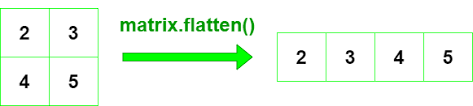

In [54]:
#add all tokens in a new DF with its associated tfidf score
#sort the toke by its tf-idf score
token_freq = (pd.DataFrame({'tfidf': dtm_tfidf.sum(axis=0).A1 #A1 to flatten the matrix to array
                            ,
                            'token': tokens})
              .sort_values('tfidf', ascending=False))

In [55]:
token_freq

,tfidf,token
22743,87.251494,said
17635,58.220783,mr
28821,41.982178,year
19471,37.303707,people
18044,34.197388,new
...,...,...
23933,0.014186,sioux
3381,0.014186,bane
3883,0.014186,biassed
8973,0.014186,duetted


In [56]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [57]:
y = pd.factorize(news_df.topic)[0] #Encode the variable as categorical variable, 0='business', 1='entertainment', 2='politics', 3='sport', 4='tech'. [0] is the array [1] is the index
X = news_df.body

#train test split based on y
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [58]:
pd.Series(y).value_counts()/len(y)

,count
3,0.229663
0,0.229213
2,0.187416
4,0.180225
1,0.173483


In [59]:
#create tfidf vectors
tfidf = TfidfVectorizer(stop_words='english')
X_train_dtm = tfidf.fit_transform(X_train)
X_test_dtm = tfidf.transform(X_test)


In [60]:
nb = MultinomialNB() #train naives bayes classifier
nb.fit(X_train_dtm, y_train)
y_pred_class = nb.predict(X_test_dtm)

In [61]:
#evaluate results
accuracy_score(y_test, y_pred_class)


0.9766606822262118

In [62]:
print(classification_report(y_true=y_test, y_pred=y_pred_class))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       128
           1       0.99      0.97      0.98        97
           2       0.94      0.99      0.96       104
           3       0.99      1.00      1.00       128
           4       0.98      0.95      0.96       100

    accuracy                           0.98       557
   macro avg       0.98      0.98      0.98       557
weighted avg       0.98      0.98      0.98       557



In [63]:
#look at the confusion matrix
pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_pred_class))


,0,1,2,3,4
0,124,0,3,0,1
1,0,94,2,0,1
2,1,0,103,0,0
3,0,0,0,128,0
4,1,1,2,1,95


In [64]:
#look at the confusion matrix with class names
pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_pred_class), index=pd.factorize(news_df.topic)[1],columns = pd.factorize(news_df.topic)[1] )

,business,entertainment,politics,sport,tech
business,124,0,3,0,1
entertainment,0,94,2,0,1
politics,1,0,103,0,0
sport,0,0,0,128,0
tech,1,1,2,1,95


In [66]:
logreg1 = LogisticRegression(solver ='saga') #use a different solver rather than the default lbfgs
logreg1.fit(X_train_dtm, y_train)
y_pred1 = logreg1.predict(X_test_dtm)


In [71]:
print(classification_report(y_true=y_test, y_pred=y_pred1))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       128
           1       0.99      0.99      0.99        97
           2       0.97      0.98      0.98       104
           3       0.98      1.00      0.99       128
           4       1.00      0.98      0.99       100

    accuracy                           0.99       557
   macro avg       0.99      0.99      0.99       557
weighted avg       0.99      0.99      0.99       557



In [72]:
#look at the confusion matrix with class names
pd.DataFrame(confusion_matrix(y_true=y_test, y_pred=y_pred1), index=pd.factorize(news_df.topic)[1],columns = pd.factorize(news_df.topic)[1] )

,business,entertainment,politics,sport,tech
business,125,0,3,0,0
entertainment,0,96,0,1,0
politics,1,0,102,1,0
sport,0,0,0,128,0
tech,1,1,0,0,98


## Conclusion



1.   Cleaning, Preprocessing, Tokenizing, Vectorizing matters
2.   Training your own may not work as well as you thought it might be
3. All comes down to ease of use, accuracy, and amount of resources used.

